The below is basic autoencoder written in tf.keras. 

The model has three dense layers, all with activation function ReLU (rectified linear unit), and He weight initialization, moreover the middle layer has L1 regularization. The autoencoder is trained to reconstruct images from mnist dataset. The data class is used to turn original sets into the form required by the model, there is also functionality to split the train set into train and validation ones. The model class contains the whole model as shown below. For simplicity, encoder and decoder parts are not explicitely distinguished (as in the convolutional autoencoder). The chosen optimizer is Adam (adaptive momentum estimation).

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [2]:
class data:
    def __init__(self, input, name):
        self.name = name
        self.normalized = input.astype("float32") / 255.
        self.final = self.normalized.reshape(input.shape[0], np.prod(input.shape[1:]))

    def train_val_split(self, val_size):
        if val_size > 1 or val_size <= 0:
            raise SyntaxError("Validation size should be a float between 0 and 1")
        perm = list(np.random.permutation(self.final.shape[0]))
        split_index = int(self.final.shape[0] * val_size)
        train_idxs = perm[:split_index]
        test_idxs = perm[split_index:]
        self.train = self.final[train_idxs]
        self.val = self.final[test_idxs]

class Model:
    def __init__(self, input):
        self.input = tf.keras.Input(shape=[784], dtype=tf.float32, name='input')
        self.layer1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu, kernel_initializer=tf.keras.initializers.he_normal(), dtype=tf.float32, name="layer1")(self.input)
        self.layer2 = tf.keras.layers.Dense(units=32, activation=tf.nn.relu, activity_regularizer=tf.keras.regularizers.l1(10e-5), kernel_initializer=tf.keras.initializers.he_normal(), dtype=tf.float32, name="layer2")(self.layer1)
        self.layer3 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu, kernel_initializer=tf.keras.initializers.he_normal(), dtype=tf.float32, name="layer3")(self.layer2)
        self.outputs = tf.keras.layers.Dense(units=784, activation='sigmoid', name='output')(self.layer3)

In [3]:
(x_train, _ ), (x_test, _ ) = mnist.load_data() ### download datasets (wihtout labels)

In [4]:
input = data(x_train, "mnist")
input.final.shape

(60000, 784)

In [5]:
input.train_val_split(0.2)
print("train size:", input.train.shape, "\nvalidation size:", input.val.shape)

train size: (12000, 784) 
validation size: (48000, 784)


In [13]:
tf.keras.backend.clear_session()

In [14]:
model = Model(input.train)
autoencoder = tf.keras.Model(model.input, model.outputs, name="Autoencoder")
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
layer2 (Dense)               (None, 32)                4128      
_________________________________________________________________
layer3 (Dense)               (None, 128)               4224      
_________________________________________________________________
output (Dense)               (None, 784)               101136    
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5,  min_delta=0.01, restore_best_weights=True)
history = autoencoder.fit(x=input.train, y=input.train, epochs=100, shuffle=True, batch_size=256, validation_data=(input.val, input.val), callbacks=[es])

Train on 12000 samples, validate on 48000 samples
Epoch 1/100
12000/12000 [==============================] - 2s 180us/sample - loss: 0.3722 - acc: 0.7449 - val_loss: 0.2432 - val_acc: 0.7938
Epoch 2/100
12000/12000 [==============================] - 1s 91us/sample - loss: 0.2132 - acc: 0.7975 - val_loss: 0.1872 - val_acc: 0.8007
Epoch 3/100
12000/12000 [==============================] - 1s 89us/sample - loss: 0.1732 - acc: 0.8030 - val_loss: 0.1614 - val_acc: 0.8054
Epoch 4/100
12000/12000 [==============================] - 1s 92us/sample - loss: 0.1529 - acc: 0.8067 - val_loss: 0.1463 - val_acc: 0.8081
Epoch 5/100
12000/12000 [==============================] - 1s 88us/sample - loss: 0.1407 - acc: 0.8088 - val_loss: 0.1367 - val_acc: 0.8090
Epoch 6/100
12000/12000 [==============================] - 1s 87us/sample - loss: 0.1331 - acc: 0.8100 - val_loss: 0.1312 - val_acc: 0.8104
Epoch 7/100
12000/12000 [==============================] - 1s 91us/sample - loss: 0.1283 - acc: 0.8107 - val_

In [16]:
test = data(x_test, "mnist_test")
pred_imgs = autoencoder.predict(test.final)

In [17]:
def reals_and_predictions(n):
    len = test.final.shape[0]
    perm = np.random.permutation(len)
    perm = perm[:n]

    ax_s = []
    for i in range(n):
        ax_s.append(str("ax") + str(i))

    f, ax_s = plt.subplots(1, n, figsize=(20,2))
    f.suptitle("Test Images", fontsize=16)
    for idx, ax in enumerate(ax_s):
        ax.imshow(test.final[perm[idx]].reshape(28, 28), cmap='gray')
        ax.axis('off')

    g, ax_s = plt.subplots(1, n, figsize=(20,2))
    g.suptitle("Reconstructed Images", fontsize=16)
    for idx, ax in enumerate(ax_s):
        ax.imshow(pred_imgs[perm[idx]].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

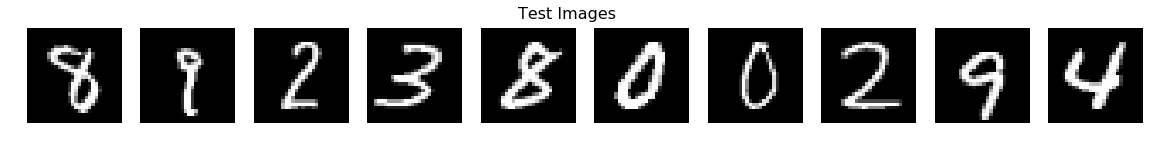

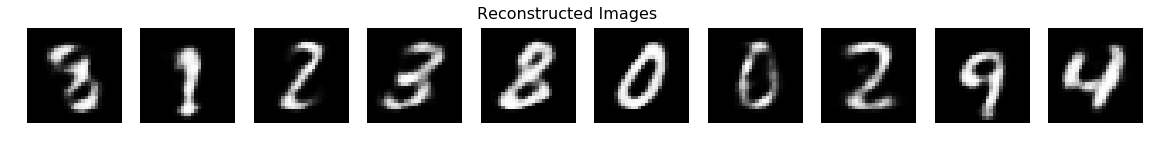

In [21]:
reals_and_predictions(10)

As we can see the above model is able to reconstruct most of digits, with the precision level on which we are able to recognize images as digits. Of course there are some numbers which cause some problems, but usually it depends on the original image, if the number is strongly deformated or not. We do not excpet very high accuracy by such simple autoencoders, so basically I would say it works properly.